In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math 

from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import minimize
import scipy.integrate as integrate
from scipy import special
from scipy.special import erf, erfc
from scipy import optimize
from datetime import date
from datetime import datetime

In [141]:
# Preprocessing
amd_quotes = pd.read_csv('amd_quotedata.csv', parse_dates=['Expiration Date'], index_col=['Expiration Date'])
amd_calls = amd_quotes.iloc[:,0:11] # Remove puts
#amd_calls = amd_calls1.drop('2023-04-06', inplace=True) # Remove date before start date

S0 = 92.3
t0 = date(2023, 4, 8)
amd_calls['Strike/Spot'] = amd_calls['Strike']/S0
amd_calls['Mid'] = (amd_calls['Bid']+amd_calls['Ask'])/2
amd_calls

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
Expiration Date,,,,,,,,,,,,,
2023-04-06,AMD230406C00083000,9.50,0.000,9.35,9.55,126,0.0000,0.9984,0.0015,144,83.0,0.899242,9.450
2023-04-06,AMD230406C00084000,8.70,0.275,8.35,8.55,35,0.0000,0.9982,0.0019,110,84.0,0.910076,8.450
2023-04-06,AMD230406C00085000,7.55,0.150,7.35,7.55,180,0.0000,0.9979,0.0024,907,85.0,0.920910,7.450
2023-04-06,AMD230406C00086000,6.63,0.205,6.35,6.55,60,0.0000,0.9976,0.0031,296,86.0,0.931744,6.450
2023-04-06,AMD230406C00087000,5.61,0.110,5.35,5.60,320,0.0000,0.9972,0.0042,308,87.0,0.942579,5.475
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-19,AMD251219C00120000,21.43,-0.220,20.95,22.30,23,0.4378,0.5719,0.0060,70,120.0,1.300108,21.625
2025-12-19,AMD251219C00125000,19.20,-1.000,19.85,20.80,5,0.4371,0.5475,0.0061,27,125.0,1.354280,20.325
2025-12-19,AMD251219C00130000,17.55,-1.225,18.50,19.45,10,0.4342,0.5238,0.0061,33,130.0,1.408451,18.975


## First maturity

In [142]:
C1 = amd_calls.loc['2023-04-14']
C1 = C1.reset_index(drop=True)
C1

,Calls,Last Sale,Net,Bid,Ask,Volume,IV,Delta,Gamma,Open Interest,Strike,Strike/Spot,Mid
0,AMD230414C00083000,9.72,-0.105,9.55,9.80,166,0.4442,0.9452,0.0172,293,83.0,0.899242,9.675
1,AMD230414C00084000,9.05,0.150,8.65,8.85,22,0.4504,0.9287,0.0217,225,84.0,0.910076,8.750
2,AMD230414C00085000,8.10,0.075,7.70,7.90,134,0.4427,0.9068,0.0272,867,85.0,0.920910,7.800
3,AMD230414C00086000,7.00,-0.125,6.80,7.00,77,0.4352,0.8782,0.0337,569,86.0,0.931744,6.900
4,AMD230414C00087000,6.20,-0.125,5.95,6.15,101,0.4259,0.8417,0.0409,544,87.0,0.942579,6.050
5,AMD230414C00088000,5.50,-0.050,5.15,5.30,192,0.4269,0.7974,0.0483,457,88.0,0.953413,5.225
6,AMD230414C00089000,4.50,-0.300,4.40,4.50,165,0.4155,0.7456,0.0556,934,89.0,0.964247,4.450
7,AMD230414C00090000,3.76,-0.340,3.70,3.80,817,0.4147,0.6869,0.0622,1864,90.0,0.975081,3.750
8,AMD230414C00091000,3.07,-0.380,3.05,3.15,1194,0.4062,0.6223,0.0677,1272,91.0,0.985915,3.100
9,AMD230414C00092000,2.50,-0.365,2.48,2.50,8647,0.4024,0.5529,0.0714,1637,92.0,0.996750,2.490


In [143]:
def iv(p,K,T,r,S0):
    """
    Calculate implied volatility using Black-Scholes formula
    
    Parameters:
    p (float): Market price(s) of the option
    K (float): Strike price(s) of the option
    T (float): Time to expiry of the option, in years
    r (float): Risk-free interest rate, as a decimal
    S0 (float): Current price of the underlying asset
    """
    
    d1 = lambda sigma: (np.log(S0/K) + (r + 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    d2 = lambda sigma: d1(sigma) - sigma*np.sqrt(T)
    option_price = lambda sigma: S0*norm.cdf(d1(sigma)) - K*np.exp(-r*T)*norm.cdf(d2(sigma))
    option_price_diff = lambda sigma: option_price(sigma) - p
    
    return fsolve(option_price_diff, 0.2*np.ones(len(p)))

In [5]:
# Which risk-free interest rate is used?
#iv_diff = lambda r: np.linalg.norm(iv(np.array(amd_calls_t1['Mid']),np.array(amd_calls_t1['Strike']),6/252,r,S0) - np.array(amd_calls_t1['IV']))
#r_ = minimize(iv_diff, 0.01)
#print(r_)

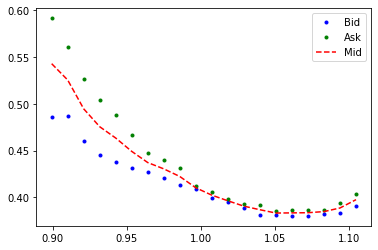

In [144]:
r = 0.01 # TODO: figure out r
ask = np.array(C1['Ask'])
bid = np.array(C1['Bid'])
mid = np.array(C1['Mid'])
K = np.array(C1['Strike'])
numK = len(K)
t1 = 6/252

# Plot data
fig, ax = plt.subplots()
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,t1,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,t1,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,t1,r,S0)), 'r--', label='Mid')
plt.legend()
plt.show()

In [145]:
#Pre-compute constants
global SQRT_PI, SQRT2, INV_SQRT2_PI, INV_SQRT2, I_CONST
SQRT2 = np.sqrt(2)
INV_SQRT2 = 1. / SQRT2
SQRT2_PI = np.sqrt(2. * np.pi)
INV_SQRT2_PI = 1. / SQRT2_PI
I_CONST = INV_SQRT2_PI / 2.

82.26725329153062


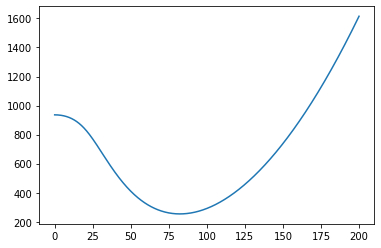

In [146]:
def sigma_objective(sigma,S0,delta_t):
    sigma += 1e-100 # to stop divide by zero errors
    sqrtt = math.sqrt(delta_t)
    help_v = (K-S0)/(SQRT2*sqrtt*sigma)
    B_vec = 0.5*(S0-K)*erf(help_v) + sigma*sqrtt*INV_SQRT2_PI*np.exp(-help_v**2)
    return np.sum((B_vec-mid)**2)


def calculate_sigma0(S0,delta_t):
    res = optimize.minimize_scalar(sigma_objective,args = (S0,delta_t))
    return res.x

sigma0 = calculate_sigma0(S0,6/252)
xx = np.linspace(0,200,1000)
f = lambda x: sigma_objective(x,S0,6/252)
f_ = np.vectorize(f)
plt.plot(xx,f_(xx))
print(sigma0)
P1 = lambda s1: 1
# P1 = lambda s1: 1 if s1 == S0 else 0

def m0(s2,s1,delta_t,P1):
    '''
    m0: Joint distribution of (s1,s2)
    P1: Marginal distribution of s1
    '''
    #renormalise m_0 on R^+
    sigma0 = calculate_sigma0(s1,delta_t)
    return norm.pdf(s2,s1,sigma0*np.sqrt(delta_t)) / norm.cdf(s1/(sigma0*np.sqrt(delta_t))) * (s1 >= 0)


def f1(V,omega):
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    l = np.zeros(numK)
    
    for i in range(numK):
        if (V[i]*omega[i] <= delta_C_ask[i]) and (V[i]*omega[i] >= delta_C_bid[i]):
            l[i] = V[i]*V[i]*omega[i]/2
        elif V[i]*omega[i] > delta_C_ask[i]:
            l[i] = delta_C_ask[i]*V[i] - delta_C_ask[i]**2/(2*omega[i])
        else: 
            l[i] = delta_C_bid[i]*V[i] - delta_C_bid[i]**2/(2*omega[i])
            
    return l


def grad_f1(V,omega):
    """
    Gradient of g1 with respect to V_K
    """
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    g = np.zeros(numK)
    
    for j in range(numK):
        if (V[j]*omega[j] <= delta_C_ask[j]) and (V[j]*omega[j] >= delta_C_bid[j]):
            g[j] = V[j]*omega[j]
        elif V[j]*omega[j] > delta_C_ask[j]:
            g[j] = delta_C_ask[j]
        else: 
            g[j] = delta_C_bid[j]
    
    return g

In [147]:
def I1(alpha,sigma,s1,K1,K2): 
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return 1/2*np.exp((alpha*sigma)**2/2 + alpha*s1) * (erf((B-alpha*sigma)*INV_SQRT2) - erf((A-alpha*sigma)*INV_SQRT2) )
    
def I2(alpha,sigma,s1,K1,K2):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return sigma*np.exp(alpha*s1) * ( 2*(np.exp(A*alpha*sigma-A*A/2) - np.exp(B*alpha*sigma-B*B/2)) + SQRT2_PI*alpha*sigma*np.exp(alpha*sigma*alpha*sigma/2)*(erf((B-alpha*sigma)*INV_SQRT2) - erf((A-alpha*sigma)*INV_SQRT2)) )
    
def I3(alpha,sigma,s1,K1,K2,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma
    return np.exp(alpha*s1) *  (2*sigma*(np.exp(A*alpha*sigma-A**2/2) - np.exp(B*alpha*sigma-B**2/2)) + SQRT2_PI*np.exp(alpha*alpha*sigma*sigma/2)*(alpha*sigma**2-Q+s1) * (erf((B-alpha*sigma)*INV_SQRT2) - erf((A-alpha*sigma)*INV_SQRT2)) )

def I4(alpha,sigma,s1,K1,K2,K,Q):
    A, B = (K1-s1)/sigma, (K2-s1)/sigma  
    return 2*sigma* (np.exp(alpha*A*sigma-A*A/2)*(sigma*(alpha*sigma+A) - K - Q + 2*s1) + np.exp(-1/2*B*(B-2*alpha*sigma))*(-sigma*(alpha*sigma+B) + K + Q -2*s1)) + SQRT2_PI*np.exp(alpha*sigma*alpha*sigma/2)*(erf((B-alpha*sigma)/(np.sqrt(2))) - erf((A-alpha*sigma)*INV_SQRT2) ) * (sigma**2 - (-alpha*sigma**2+K-s1)*(alpha*sigma**2-Q+s1))
    


In [148]:
def I_u_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)

def I_u(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_u_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1) )[0]

def I_u_(theta,V,K,s1,K1,K2,delta_t,P1): 
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*s1)
        #print(f'alpha = {alpha}')
        #print(f'sigma = {sigma}')

        if i == -1: 
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K1,K[0])
        elif i >= 0 and i < numK-1:
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        else:
            newPiece = np.exp(gamma) * I1(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI

debug = False
if debug:
    # Check whether symbolic integration is correct
    print(I_u(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
    for i in range(0,numK-1):
        print(I_u(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
    print(I_u(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

    print("----")

    print(I_u_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
    print(I_u(0,np.zeros(numK),K,S0,0,110,6/252,P1))

    print("---------")
    print(I_u_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list

In [149]:
def I_h_0_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,delta_t,P1)*(s-s1)

def I_h_0(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]

def I_h_0_(theta,V,K,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    totI = 0
    
    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*theta
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(theta*S0)
        
        if i == -1: 
            newPiece = np.exp(gamma) * I_CONST * I2(alpha,sigma,s1,K1,K[0])
        elif i >= 0 and i < numK-1:
            newPiece = np.exp(gamma) * I_CONST * I2(alpha,sigma,s1,K[i],K[i+1]) # Piecewise integration
        else:
            newPiece = np.exp(gamma) * I_CONST * I2(alpha,sigma,s1,K[-1],K2)
        
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece
    
    return totI

debug = False
if debug:
    # Check whether symbolic integration is correct
    print(I_h_0(0,np.zeros(numK),K,S0,0,K[0],6/252,P1))
    for i in range(0,numK-1):
        print(I_h_0(0,np.zeros(numK),K,S0,K[i],K[i+1],6/252,P1))
    print(I_h_0(0,np.zeros(numK),K,S0,K[-1],110,6/252,P1))

    print("----")

    print(I_h_0_(0,np.zeros(numK),K,S0,0,110,6/252,P1))
    print(I_h_0(0,np.zeros(numK),K,S0,0,110,6/252,P1))

    print("---------")
    print(I_h_0_(np.zeros(4),np.zeros(numK),K,S0,0,110,6/252,P1)) # theta can also be a list

def I_h_0_grad_integrand(s,theta,V,K,s1,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-S0))*m0(s,s1,delta_t,P1)*(s-s1)**2
    
def I_h_0_grad(theta,V,K,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_h_0_grad_integrand,K1,K2,args=(theta,V,K,s1,delta_t,P1))[0]


def I_h_0_hessian_integrand(s,theta,V,K,s1,sigma0,delta_t,P1):
    return np.exp(-np.sum(V*np.maximum(s-K,0))+K.size*theta*(s-s1))*m0(s,s1,sigma0,delta_t,P1)*(s-s1)**3

def I_h_0_hessian(theta,V,K,s1,K1,K2,sigma0,delta_t,P1):
    return integrate.quad(I_h_0_hessian_integrand,K1,K2,args=(theta,V,K,s1,sigma0,delta_t,P1))[0]


In [150]:
def I_Q_integrand(s,h0,V,K,Q,s1,delta_t,P1):
    return math.exp(-np.sum(V*np.maximum(s-K,0))+K.size*h0*(s-S0))*m0(s,s1,delta_t,P1)*np.maximum(s-Q,0)

def I_Q(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    return integrate.quad(I_Q_integrand,K1,K2,args=(h0,V,K,Q,s1,delta_t,P1))[0]

I_Q_CONST = 1/(2*np.sqrt(2*math.pi))
def I_Q_(h0,V,K,Q,s1,K1,K2,delta_t,P1):
    #assert(K1 <= K[0] and K2 >= K[-1])
    sigma0 = calculate_sigma0(s1,delta_t)
    sigma = sigma0*np.sqrt(delta_t)
    Q = np.array(Q)
    if (Q.shape == ()):
      totI = np.zeros(1)
    else:
      totI = np.zeros(Q.shape)

    for i in range(-1,numK): 
        alpha = -sum(V[:i+1]) + numK*h0
        gamma = sum(V[:i+1]*K[:i+1]) - numK*(h0*S0)
        
        if i == -1: 
            newPiece = np.exp(gamma) * I_Q_CONST * I3(alpha,sigma,s1,Q,K[0],Q) * (K[0] >= Q)
        elif i >= 0 and i < numK-1:
            newPiece = np.exp(gamma) * I_Q_CONST * I3(alpha,sigma,s1,np.maximum(Q,K[i]),K[i+1],Q) * (K[i+1] >= Q)
        else:
            newPiece = np.exp(gamma) * I_Q_CONST * I3(alpha,sigma,s1,np.maximum(Q,K[-1]),K2,Q)
            
        #print(f' i = {i}: newPiece = {newPiece}')
        totI += newPiece

    return totI

debug = False
if debug:
    # Check whether symbolic integration is correct
    print(I_Q(0,np.zeros(numK),K,K[0],S0,0,K[0],6/252,P1))
    for i in range(0,numK-1):
        print(I_Q(0,np.zeros(numK),K,K[0],S0,K[i],K[i+1],6/252,P1))
    print(I_Q(0,np.zeros(numK),K,K[0],S0,K[-1],110,6/252,P1))


    print("---------")
    #print(I_Q_(np.zeros(4),np.zeros(numK),K,K[0],S0,0,110,6/252,P1)) # h0 can also be a list

    print("----")
    # Check for different Q's
    print(I_Q_(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))
    print(I_Q(0,np.zeros(numK),K,K[0]-10,S0,0,110,6/252,P1))

    print(I_Q_(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))
    print(I_Q(0,np.zeros(numK),K,K[0],S0,0,110,6/252,P1))

    print(I_Q_(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))
    print(I_Q(0,np.zeros(numK),K,K[3],S0,0,110,6/252,P1))

    print(I_Q_(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))
    print(I_Q(0,np.zeros(numK),K,K[-1],S0,0,110,6/252,P1))

    print(I_Q_(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))
    print(I_Q(0,np.zeros(numK),K,K[-1]+5,S0,0,110,6/252,P1))

In [151]:
def integrand_G1(s,V,u0,h0,K,omega,S0,delta_t,P1):
    return m0(s,S0,delta_t,P1)*np.exp(-np.sum(V*np.maximum(s-K,0))+(u0-h0*(s-S0))*K.size) 

def G1(V,u0,h0,K,omega,S0,delta_t,P1):
    #expectation = integrate.quad(integrand_G1,0,S0+3*sigma0,args=(V,u0,h0,K,omega,S0,sigma0,t1))[0]
    expectation = I_u_(h0,V,K,S0,S0-50, S0+50,delta_t,P1)*np.exp(-u0) # Gives the same result as the other one! -> Confirms P_sig0 = delta(s-S0)
    #print (f'G1 = {u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation}')
    return u0 + np.sum(V*mid) + np.sum(f1(V,omega)) + expectation

    
def grad_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    """
    Gradient of G_12 with respect to V_K_i
    """
    gf1 = grad_f1(V,omega)
    grad = np.zeros(numK)
    grad = gf1 + mid - I_Q_(h0,V,K,K,S0,S0-50,S0+50,delta_t,P1)*np.exp(-u0) # second K is Q in notation
    
    #print(f'Grad = {grad}')
    #print(f'Grad norm = {np.linalg.norm(grad)}')
    return grad

def Hess_G1(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Hessian of G_12
    '''
    #calculate the expectation appearing in the Hessian
    Max = np.zeros((numK,numK))
    Sum = np.zeros((numK,numK))
    Prod = np.zeros((numK,numK))
    for i in range(numK):
        for j in range(numK):
            Max[i,j] = max(K[i], K[j])
            Sum[i,j] = K[i] + K[j]
            Prod[i,j] = K[i] * K[j]

    # Pre-compute some constants
    std = sigma0 * np.sqrt(delta_t)
    H_help = (Max - S0)/(np.sqrt(2)*std)
    RENORM_CONST =  1/norm.cdf(S0/(sigma0*np.sqrt(delta_t)))
    H = (std**2 + S0**2 - Sum*S0 + Prod)/2. * erfc(H_help) \
        + std * np.exp(-H_help**2) * INV_SQRT2_PI * (Max + S0 - Sum)
    H *= RENORM_CONST

    #calculate del_V_j^2 f  
    delta_C_bid = bid - mid
    delta_C_ask = ask - mid
    
    help_v_1 = np.less_equal(V*omega,delta_C_ask ).astype(int)
    help_v_2 = np.greater_equal(V*omega,delta_C_bid).astype(int)
    diag_f_del_2 = V*(help_v_1+help_v_2-1)
    f_del_2 = np.diag(diag_f_del_2)
    
    return f_del_2 + H

In [152]:
def grad_G1_comparison(V,u0,h0,K,omega,S0,delta_t,P1):
    '''
    Check whether the expression of the gradient is correct, by comparing it to a finite difference approximation
    '''
    grad = grad_G1(V,u0,h0,K,omega,S0,delta_t,P1)
    
    grad_FD = np.zeros(numK)
    eps = 1e-7
    for i in range(numK):
        D = np.zeros(numK)
        D[i] = eps
        grad_FD[i] = (G1(V+D,u0,h0,K,omega,S0,delta_t,P1)-G1(V,u0,h0,K,omega,S0,delta_t,P1))/eps
        
    #print(f'Grad = {grad}')
    #print(f'Grad_FD = {grad_FD}')
    print(f'Maximum difference: {max(grad - grad_FD)}')

u0, h0, V = 0., 0., [0.]*numK
p0 = np.array([u0] + [h0] + V)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)

grad_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,6/252,P1)

Maximum difference: -1.000284473473556e-06


In [153]:
def Hess_G1_comparison(V,u0,h0,K,omega,S0,sigma0,t1):
    '''
    Check whether the expression of the Hessian is correct, by comparing it to a finite difference approximation
    '''
    Hess = Hess_G1(V,u0,h0,K,omega,S0,sigma0,t1)
    u = np.ones(numK)
    eps = 1e-7
    
    Hess_u = Hess.dot(u)
    Hess_u_FD = (grad_G1(V+eps*u,u0,h0,K,omega,S0,sigma0,t1)-grad_G1(V,u0,h0,K,omega,S0,sigma0,t1))/eps
    
    print(f'Hess_u = {Hess_u}')
    print(f'Hess_u_FD = {Hess_u_FD}')

Hess_G1_comparison(np.zeros(numK),u0,h0,K,omega_K,S0,sigma0,t1)

Hess_u = [10236153.46711919 10225316.71366408 10214479.96134462 10203643.21210766
 10192806.46887354 10181969.73553609 10171133.01696264 10160296.31899404
 10149459.64844463 10138623.01310221 10127786.42172803 10116949.88405674
 10106113.41079631 10095277.01362802 10084440.70520634 10073604.49915884
 10062768.41008615 10051932.4535618  10041096.6461321  10030261.00531607]
Hess_u_FD = [2608.10650891 2498.71381214 2389.35604084 2280.08309394 2170.98205752
 2062.16944592 1953.80742259 1846.09386988 1739.25122175 1633.53102567
 1529.23925585 1426.6734568  1326.16885282 1228.06660812 1132.70146506
 1040.42201922  951.55290916  866.4012039   785.25126311  708.34832296]


In [154]:
u1, h1, V = 0., 0., np.array([0.]*numK)
V_prev = np.array([1] *numK)
Lambda = 0.1
omega_K = Lambda * np.abs(ask - bid)
delta_t = 6/252 #TODO: think about amount of trading days!
P1 = lambda s1: 1

debug = False
while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:
    V_prev = V
    h0 = optimize.root_scalar(I_h_0_,args=(V,K,S0,S0-50, S0+50,delta_t,P1) ,bracket = [-0.02,0.02],x0=0.00005, fprime = I_h_0_grad, fprime2 = I_h_0_hessian).root
    #u1 = -math.log(1/(I_u(h1,V,K,s1,sigma_0,t1)))
    u0 = np.log(I_u_(h0,V,K,S0,S0-50, S0+50,delta_t,P1))

    V = optimize.minimize(fun= G1, x0=V, args=(u0,h0,K,omega_K,S0,delta_t,P1), method='Newton-CG', jac= grad_G1, hess= Hess_G1, hessp=None, bounds=None, constraints=(), tol=1e-5, callback=None, options=None).x
    
    if debug:
        print(f' h0 = {h0}')
        print(f' u0 = {u0}')
        print(f'V = {V}')
        print(f'normdiff = {np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev)}')
        print("----------")

C:\Users\lachl\AppData\Local\Temp/ipykernel_27932/912387179.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  while np.linalg.norm(V-V_prev)/np.linalg.norm(V_prev) > 1e-5:


In [155]:
n = numK
xx = np.linspace(83, 102, n, endpoint = True)
c = I_Q_(h0,V,K,xx,S0,50,120,delta_t,P1)*np.exp(-u0)
#for i in range(n):
    # print(f'K={xx[i]}, C = {c[i]}')

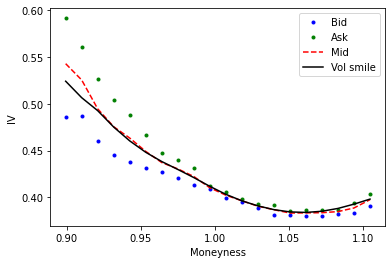

In [156]:
# Plot data
fig, ax = plt.subplots()
T_ = 6/252
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(bid,K,T_,r,S0)), 'b.', label='Bid')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(ask,K,T_,r,S0)), 'g.', label='Ask')
ax.plot(np.array(C1['Strike/Spot']), np.array(iv(mid,K,T_,r,S0)), 'r--', label='Mid')
v = np.zeros(n)
for i in range(n):
    v[i] = iv(np.array([c[i]]), np.array([xx[i]]), T_, r, S0)
ax.plot(xx / S0, v, 'k', label='Vol smile')
ax.set_ylabel('IV')
ax.set_xlabel('Moneyness')
plt.legend()
plt.show()